In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
import pandas as pd
import os
sns.set()

sns.set_style('white', {'axes.linewidth': 4})
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['xtick.major.size'] = 20
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
# import dataframe_image as dfi

In [85]:
# %pip install biopython
import pickle
import Bio
from Bio.SeqUtils import GC
from Bio.Data import CodonTable
from Bio import Entrez
from Bio import SeqIO
from Bio import pairwise2 as pw
from Bio import AlignIO
from Bio import Align as al
EMAIL = 's1905547@ed.ac.uk'
Entrez.email = EMAIL
file_sources = "../sources/"

In [86]:

#Reads the sfari gene file
sfari = pd.read_csv(file_sources+"SFARI-Gene_genes_11-07-2022release_11-26-2022export.csv")
sfari = sfari.sort_values("number-of-reports", ascending=False)


## Task 1

In [87]:
df_categorical_byscore = sfari.groupby(['gene-score'])
df_categorical_byscore.count()


,status,gene-symbol,gene-name,ensembl-id,chromosome,genetic-category,syndromic,eagle,number-of-reports
gene-score,,,,,,,,,
1.0,214,214,214,214,214,214,214,142,214
2.0,695,695,694,686,695,693,695,8,695
3.0,91,91,91,91,91,91,91,0,91


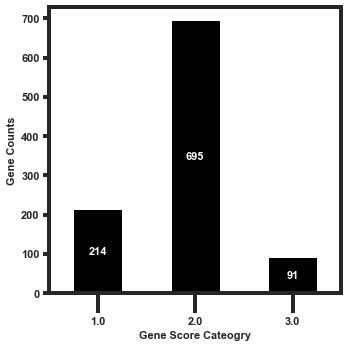

In [88]:
p1 = df_categorical_byscore.count()['gene-symbol'].plot(figsize=(5,5),kind='bar',color='black',fontsize=11,legend=False,rot=0)
p1.bar_label(p1.containers[0],label_type='center',fontsize=11,color='white')

p1.set_xlabel('Gene Score Cateogry',fontsize=11)
p1.set_ylabel('Gene Counts',fontsize=11)
plt.tight_layout()

plt.show()

## Task 2

In [89]:
focus_genes = sfari[sfari['gene-score'] == 1.0][0:5].sort_values("number-of-reports", ascending=False)
focus_genes_list = focus_genes['gene-symbol'].values # Top 5 Genes

(focus_genes['number-of-reports'].sum()/df_categorical_byscore['number-of-reports'].sum().values[0])*100

10.261080752884032

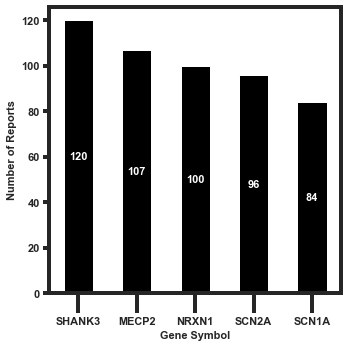

In [90]:
p2 = focus_genes.plot(x='gene-symbol',y='number-of-reports',figsize=(5,5),kind='bar',color='black',fontsize=11,legend=False,rot=0)
p2.bar_label(p2.containers[0],label_type='center',fontsize=11,color='white')

p2.set_xlabel('Gene Symbol',fontsize=11)
p2.set_ylabel('Number of Reports',fontsize=11)
plt.tight_layout()

plt.show()

## Task 3

In [304]:

data_pubmed_byyear = np.empty((5,23))
idlist_pubmed_byyear =[]
years = np.arange(2000,2023,1) #no reports before 2000
pmid_report= []
for i in range(5):
    gene = focus_genes_list[i]
    for j in range(23):
        year = years[j]
        handle =Entrez.esearch(db="pubmed",term=f"({gene} AND (Autism Spectrum Disorder[mh]) AND ({year}[edat])",retmax=1000)
        # handle =Entrez.esearch(db="pubmed",term=f"({gene} protein, human[mh]) AND ({year}[edat])")
        record = Entrez.read(handle)
        handle.close()
        data_pubmed_byyear[i,j] = record["Count"] # taking into account the count parameter
        # data_pubmed_byyear[i,j] = len(record["IdList"]) # I think SFARI uses something like this and without the retmax set.
        
        pmid_report.extend(record["IdList"])
        
        for pmid in record["IdList"]:
            handle = Entrez.elink(dbfrom="pubmed",linkname ='pubmed_pubmed_citedin',id=pmid)
            record_ref = Entrez.read(handle)
            handle.close()
            if record_ref[0]['LinkSetDb'] != []:
                idlist_pubmed_byyear.append([gene,year,pmid,len(record_ref[0]['LinkSetDb'][0]["Link"])])

#UNCOMMENT TO ADD CITED IN DATA       
#         for pmid in  record["IdList"]:
#             record = Entrez.read(Entrez.elink(dbfrom="pubmed", id=pmid))
#             for linksetdb in record[0]["LinkSetDb"]:
#                 if linksetdb["LinkName"] == "pubmed_pubmed_citedin":
#                     idlist_pubmed_byyear.append([gene,year,pmid,len(linksetdb["Link"])])
 
np.savetxt('csv/task3_table.csv',np.c_[focus_genes_list,data_pubmed_byyear],header="Gene Symbol,"+",".join(map(str, years)),delimiter=",",fmt='%s',comments='')                 
np.savetxt('csv/task3_citation.csv',idlist_pubmed_byyear,header="Gene Symbol,Year,PubMed ID,Cited In",delimiter=",",fmt='%s',comments='')
np.savetxt('csv/pmid_report.csv',pmid_report,header='pmid',comments='',fmt='%s')                     


## Task 4

In [330]:
PubMed_table_data = pd.read_csv('task3_table_rt.csv')
PubMed_table_data

,Gene Symbol,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,SHANK3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,6.0,...,3.0,2.0,5.0,14.0,7.0,9.0,12.0,9.0,12.0,20.0
1,MECP2,2.0,1.0,2.0,4.0,4.0,3.0,4.0,7.0,4.0,...,3.0,2.0,5.0,12.0,8.0,1.0,4.0,8.0,3.0,5.0
2,NRXN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,...,7.0,3.0,2.0,3.0,3.0,4.0,7.0,5.0,7.0,5.0
3,SCN2A,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,1.0,2.0,3.0,2.0,3.0,4.0,6.0,6.0,6.0
4,SCN1A,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,0.0,1.0,1.0,4.0,5.0,1.0


In [331]:
PubMed_table_data_T = PubMed_table_data.set_index('Gene Symbol').T.reset_index()
Total_count = PubMed_table_data_T.astype(int).sum()

label_names = (Total_count.keys() +" - "+ Total_count.values.astype(str)).to_list()
label_names[0] = "Year"

PubMed_table_data_T.columns = label_names
# PubMed_table_data.style.to_latex(
#     position='h!',label="PubMed_byYear_table",
#     caption="Number of PubMed Reports over the Years for the Top 5 Genes in SFARI Category 1. There are no reports before 2000",
#     position_float="centering",multicol_align="|c|")

In [332]:
PubMed_table_data_T


,Year,SHANK3 - 120,MECP2 - 107,NRXN1 - 63,SCN2A - 40,SCN1A - 22
0,2000,0.0,2.0,0.0,0.0,0.0
1,2001,0.0,1.0,0.0,0.0,0.0
2,2002,0.0,2.0,0.0,0.0,0.0
3,2003,0.0,4.0,0.0,1.0,1.0
4,2004,0.0,4.0,0.0,2.0,3.0
5,2005,1.0,3.0,0.0,0.0,0.0
6,2006,1.0,4.0,0.0,0.0,0.0
7,2007,2.0,7.0,3.0,0.0,0.0
8,2008,6.0,4.0,2.0,1.0,0.0
9,2009,3.0,10.0,6.0,0.0,0.0


## Task 5

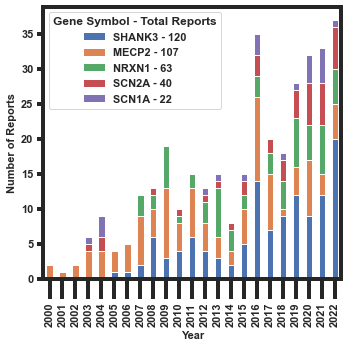

In [333]:
years = np.arange(2000,2023,1)
PubMedHist = PubMed_table_data_T.plot.bar(x='Year', figsize=(5,5),fontsize=11,stacked = True)
# PubMedHist.bar_label(PubMedHist.containers[0])
PubMedHist.set_xlabel('Year',fontsize=11)
PubMedHist.set_ylabel('Number of Reports',fontsize=11)
plt.tight_layout()
plt.legend(title="Gene Symbol - Total Reports")
plt.savefig('plots/pubmed-hist-1.png')
plt.show()



https://gene.sfari.org/user-guide/human-gene-module/

## Analysis

In [309]:
np.savetxt('csv/task3_citation.csv',idlist_pubmed_byyear,header="Gene Symbol,Year,PubMed ID,Cited In",delimiter=",",fmt='%s',comments='')

In [312]:
PubMed_cite = pd.read_csv('csv/task3_citation.csv').sort_values('Cited In',ascending=False).reset_index()
highly_cited = PubMed_cite.nlargest(6,'Cited In')
# PubMed_cite.loc[PubMed_cite['PubMed ID'] == highly_cited['PubMed ID'].values[4]]
highly_cited

,index,Gene Symbol,Year,PubMed ID,Cited In
0,491,SCN1A,2012,22495309,1093
1,441,SCN2A,2012,22495306,1030
2,10,SHANK3,2008,18252227,832
3,369,NRXN1,2008,18252227,832
4,1,SHANK3,2006,17173049,682
5,377,NRXN1,2009,19404257,675


In [315]:
name = ["O'Roak et al.","Sanders et al.","Marshall et al.","Marshall et al.",'Durand et al.',"Glessner et al."]
highly_cited["Paper"] = name
highly_cited = highly_cited[['Paper','Year','Gene Symbol','Cited In']]
highly_cited

,Paper,Year,Gene Symbol,Cited In
0,O'Roak et al.,2012,SCN1A,1093
1,Sanders et al.,2012,SCN2A,1030
2,Marshall et al.,2008,SHANK3,832
3,Marshall et al.,2008,NRXN1,832
4,Durand et al.,2006,SHANK3,682
5,Glessner et al.,2009,NRXN1,675


O' Roak et al. - 10.1038/nature10989 - Sporadic autism exomes reveal a highly interconnected protein network of de novo mutations. Sporadic ASD Experimental comparsion. CNV

Sanders et al. - 10.1038/nature10945 - Among a total of 279 identified de novo coding mutations, there is a single instance in probands, and none in siblings, in which two independent nonsense variants disrupt the same gene, SCN2A (sodium channel, voltage-gated, type II, α subunit), a result that is highly unlikely by chance.

Marshall et al. - 10.1016/j.ajhg.2007.12.009- Structural variants were found in sufficiently high frequency influencing ASD to suggest that cytogenetic and microarray analyses be considered in routine clinical workup.

Durand et al. - 10.1038/ng1933 - In this paper, we report evidence showing that abnormal gene dosage of SHANK3 is associated with severe cognitive deficits, including language and speech disorder and ASD. deletion

Glessner et al. - 10.1038/nature07953  Although these variants may be individually rare, they target genes involved in neuronal cell-adhesion or ubiquitin degradation, indicating that these two important gene networks expressed within the central nervous system may contribute to the genetic susceptibility of ASD.


https://pubmed.ncbi.nlm.nih.gov/26511836/ SHANK3 drug

MECP2 drug

1. SCN1A and 2A are well documented because of their relation to epilepsy.
2. 


In [316]:
print(highly_cited.to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))

\begin{table}
\centering
\caption{Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.}
\begin{tabular}{lrlr}
\toprule
          Paper &  Year & Gene Symbol &  Cited In \\
\midrule
  O'Roak et al. &  2012 &       SCN1A &      1093 \\
 Sanders et al. &  2012 &       SCN2A &      1030 \\
Marshall et al. &  2008 &      SHANK3 &       832 \\
Marshall et al. &  2008 &       NRXN1 &       832 \\
  Durand et al. &  2006 &      SHANK3 &       682 \\
Glessner et al. &  2009 &       NRXN1 &       675 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_53676/3771239504.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(highly_cited.to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))


In [285]:
PubMed_cite.groupby(['Gene Symbol'])['Cited In'].sum()

Gene Symbol
MECP2      7509
NRXN1      3243
SCN1A       731
SCN2A      2771
SHANK3    12491
Name: Cited In, dtype: int64

In [286]:
print(PubMed_cite.groupby(['Gene Symbol'])['Cited In'].sum().to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))


\begin{table}
\centering
\caption{Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.}
\begin{tabular}{r}
\toprule
 Cited In \\
     7509 \\
\midrule
     3243 \\
      731 \\
     2771 \\
    12491 \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_53676/38227247.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(PubMed_cite.groupby(['Gene Symbol'])['Cited In'].sum().to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))


## Co-citation Analysis

In [287]:
pmids = pd.read_csv('csv/pmid_report.csv')


In [296]:
citation_matrix = []

for pmid in  pmids.values:
      
        cit = []
        handle = Entrez.elink(dbfrom="pubmed",linkname = 'pubmed_pubmed_refs',id=pmid)
        record = Entrez.read(handle)
        handle.close()
    
        if record[0]['LinkSetDb'] != []:
            for json_id in (record[0]['LinkSetDb'][0]['Link']):
                
                cit.append(json_id['Id'])
    
        citation_matrix.append(cit)   

        
    

In [297]:
citation_matrix_N = np.asarray(citation_matrix,dtype=object)


In [298]:
citation_matrix_N.size

578

In [299]:
np.savetxt('all_cited.txt',citation_matrix_N,fmt='%s',delimiter=',')

In [300]:
unavail_paper_index =[]
for i,j in enumerate(citation_matrix_N):
    
    if len(j) == 0:
        unavail_paper_index.append(i)


In [301]:
len(unavail_paper_index)

205

205 pmid dont have cite data out of 578

In [322]:
f = np.concatenate(citation_matrix_N).ravel()

f =np.unique(f,return_counts=True)

ranking =np.argsort(f[1])[::-1]




13795

In [323]:
np.savetxt('csv/cociteAnalysis.csv',np.c_[f[0][ranking],f[1][ranking],100*f[1][ranking]/len(f[1])
],header="pmid cite-count cite-percent",comments='',fmt='%s')

In [324]:
cc = pd.read_csv('csv/cociteAnalysis.csv',delimiter=' ')
top5 = cc[:5].copy()
top5

,pmid,cite-count,cite-percent
0,21423165,118,0.855382
1,17173049,115,0.833635
2,21167025,81,0.587169
3,21558424,79,0.572671
4,25188300,70,0.507430


In [328]:
top5['Paper'] = ['Peça et al.(2011)','Durand et al.(2007)','Bozdagi et al.(2011)','Wang et al.(2010)','Leblond et al.(2014)']
top5['cite-percent'] =(top5['cite-percent']*100).astype(str) + '%' 

peca et al - 10.1038/nature09965 Here we show that mice with Shank3 gene deletions exhibit self-injurious repetitive grooming and deficits in social interaction.(2011)


Durand et al. - 10.1038/ng1933  - Here, we report that a mutation of a single copy of SHANK3 on chromosome 22q13 can result in language and/or social communication disorders. These mutations concern only a small number of individuals,(2007)

Bozdagi et al. - 10.1186/2040-2392-1-15 - We documented specific deficits in synaptic function and plasticity, along with reduced reciprocal social interactions in Shank3 heterozygous mice. Our results are consistent with altered synaptic development and function in Shank3 haploinsufficiency, highlighting the importance of Shank3 in synaptic function and supporting a link between deficits in synapse function and neurodevelopmental disorders. The reduced glutamatergic transmission that we observed in the Shank3 heterozygous mice represents an interesting therapeutic target in Shank3-haploinsufficiency syndromes.(2010)

Wang et al. - 10.1093/hmg/ddr212 - We conclude that loss of major Shank3 species produces biochemical, cellular and morphological changes, leading to behavioral abnormalities in mice that bear similarities to human ASD patients with SHANK3 mutations. (2011)

Leblond et al. - 10.1371/journal.pgen.1004580 - In summary, mutations of the SHANK genes were detected in the whole spectrum of autism with a gradient of severity in cognitive impairment. Given the rare frequency of SHANK1 and SHANK2 deleterious mutations, the clinical relevance of these genes remains to be ascertained. In contrast, the frequency and the penetrance of SHANK3 mutations in individuals with ASD and intellectual disability-more than 1 in 50-warrant its consideration for mutation screening in clinical practice. (2014 sep)




In [329]:
top5

,pmid,cite-count,cite-percent,Paper
0,21423165,118,0.8553823849220732%0.8553823849220732%0.855382...,Peça et al.(2011)
1,17173049,115,0.8336353751359188%0.8336353751359188%0.833635...,Durand et al.(2007)
2,21167025,81,0.5871692642261689%0.5871692642261689%0.587169...,Bozdagi et al.(2011)
3,21558424,79,0.572671257702066%0.572671257702066%0.57267125...,Wang et al.(2010)
4,25188300,70,0.5074302283436027%0.5074302283436027%0.507430...,Leblond et al.(2014)


In [327]:
print(top5[['Paper','cite-percent']].to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))


\begin{table}
\centering
\caption{Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.}
\begin{tabular}{ll}
\toprule
               Paper &        cite-percent \\
\midrule
   Peça et al.(2011) & 0.8553823849220732\% \\
 Durand et al.(2007) & 0.8336353751359188\% \\
Bozdagi et al.(2011) & 0.5871692642261689\% \\
   Wang et al.(2010) &  0.572671257702066\% \\
Leblond et al.(2014) & 0.5074302283436027\% \\
\bottomrule
\end{tabular}
\end{table}



/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_53676/414602516.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top5[['Paper','cite-percent']].to_latex(index=False,multicolumn=True,caption='Table of ASD related PubMed Report counts for genes for each year from 2000 to 2022.'))
